# Seattle Housing Prices - Predictive Modeling

### Workflow:

1. Feature Engineering
    - (a) Create dummy variables
    - (b) Adjusting year_renovated column as categorical (yes or no) rather than by date
    - (c) Drop sqft_lot and sqft_lot15
    
    
2. Create Train_Test_Split


3. Run baseline model
    - print RMSE


4. Iterate on model:
    - (a) Remove outliers
    - (b) Remove collinear variables
    - (c) Log transformations
    - (d) Drop non-sig p-values
    - (e) Unit Vectorization (update x-columns to add in unit vectors composed of collinear variables)
    
 

### Plan so far...

#### Dependent Variable:

    - Price

#### Explanatory Variables:

    - Keep: ['bedrooms',
             'bathrooms',
             'sqft_living',
             'floors',
             'sqft_above',
             'sqft_basement',
             'sqft_living15',
             'view',
             'waterfront',
             'yr_built]
    
    - Drop: ['sqft_lot', 'sqft_lot15']
    
    - Create dummies: ['condition', 'zipcode', 'grade']
    
    - Convert to binary: ['yr_renovated']
    
    - Will have to think of a plan for latitude and longitude

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

#### Import and drop columns:

In [2]:
house_data = pd.read_csv('house_data_cleaned.csv')
house_data.drop(['sqft_lot', 'sqft_lot15'], axis=1, inplace=True)
house_data.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
0,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800


In [3]:
# 17 columns going on 97...
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   waterfront     21597 non-null  float64
 6   view           21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  float64
 11  yr_built       21597 non-null  int64  
 12  yr_renovated   21597 non-null  float64
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
dtypes: float64(9), int64(8)
memory usage: 2.8 MB


#### Create dummy variables:

In [4]:
# Create a binary renovated column to determine whether the home was renovated or not
# Since the year renovated is not actionable unless we specialize in selling renovated homes from specific years
# but this way we can determine whether we should focus on renovations or not
house_data['yr_renovated'] = house_data.yr_renovated.apply(lambda x: 1 if x > 0 else 0)
house_data.rename(columns = {"yr_renovated":"renovated"}, inplace=True)

In [5]:
# Drop first variable so they do not reference one another
cond_dum = pd.get_dummies(house_data['condition'], prefix='cond_', drop_first=True)
grade_dum = pd.get_dummies(house_data['grade'], prefix='grade_', drop_first=True)
view_dum = pd.get_dummies(house_data['view'], prefix='view_', drop_first=True)
zipcode_dum = pd.get_dummies(house_data['zipcode'], prefix='zipcode_', drop_first=True)
zipcode_dum.head()

,zipcode__98002,zipcode__98003,zipcode__98004,zipcode__98005,zipcode__98006,zipcode__98007,zipcode__98008,zipcode__98010,zipcode__98011,zipcode__98014,...,zipcode__98146,zipcode__98148,zipcode__98155,zipcode__98166,zipcode__98168,zipcode__98177,zipcode__98178,zipcode__98188,zipcode__98198,zipcode__98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Now to merge dummy columns onto our dataframe
upHouse_data = pd.concat([house_data, cond_dum, grade_dum,view_dum, zipcode_dum], axis=1)
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Columns: 104 entries, price to zipcode__98199
dtypes: float64(8), int64(9), uint8(87)
memory usage: 4.6 MB


In [7]:
# Dropping un-dummied columns
upHouse_data.drop(columns=['condition', 'zipcode','view', 'grade', 'lat', 'long'], inplace=True)
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 98 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21597 non-null  float64
 1   bedrooms        21597 non-null  int64  
 2   bathrooms       21597 non-null  float64
 3   sqft_living     21597 non-null  int64  
 4   floors          21597 non-null  float64
 5   waterfront      21597 non-null  float64
 6   sqft_above      21597 non-null  int64  
 7   sqft_basement   21597 non-null  float64
 8   yr_built        21597 non-null  int64  
 9   renovated       21597 non-null  int64  
 10  sqft_living15   21597 non-null  int64  
 11  cond__2         21597 non-null  uint8  
 12  cond__3         21597 non-null  uint8  
 13  cond__4         21597 non-null  uint8  
 14  cond__5         21597 non-null  uint8  
 15  grade__4        21597 non-null  uint8  
 16  grade__5        21597 non-null  uint8  
 17  grade__6        21597 non-null 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


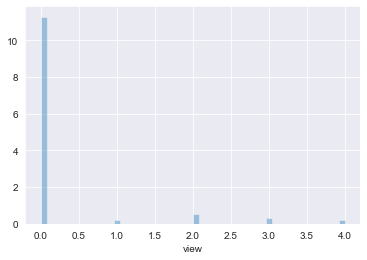

In [8]:
sns.distplot(house_data.view)

In [9]:
house_data['view'].value_counts()

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

### Now Train-Test-Split

... in preparation for our baseline model

In [29]:
# Your code here - Define the target and predictors
outcome = 'price'
feat_cols = list(upHouse_data.columns)
feat_cols.remove(outcome)

In [30]:
X = upHouse_data[feat_cols]
y = upHouse_data['price']

In [31]:
# Initial test-size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)
print(len(X_train), len(y_test))
X_train.head()

15117 6480


,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_above,sqft_basement,yr_built,renovated,sqft_living15,...,zipcode__98146,zipcode__98148,zipcode__98155,zipcode__98166,zipcode__98168,zipcode__98177,zipcode__98178,zipcode__98188,zipcode__98198,zipcode__98199
4900,3,1.00,1200,1.0,0.0,1200,0.0,1969,0,1230,...,0,0,0,0,0,0,0,0,0,0
19664,3,2.50,1920,1.0,0.0,1920,0.0,2014,0,2010,...,0,0,0,0,0,0,0,0,0,0
13949,3,1.75,1590,1.5,0.0,1590,0.0,1926,0,1820,...,0,0,0,0,0,0,0,0,0,0
15272,4,4.00,2530,3.0,0.0,2100,430.0,2013,0,2160,...,0,0,0,0,0,0,0,0,0,0
14411,3,2.50,2010,2.0,0.0,1390,620.0,2014,0,1690,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

### Vanilla Model

#### Side Note: Model Function

In [33]:
# I don't need those predictors/formulas
def training_model(predictor_cols, outcome, y_train, X_train):
    predictors = '+'.join(predictor_cols)
    formula = outcome + '~' + predictors
    model_vanilla = sm.OLS(y_train, X_train).fit()
    return model_vanilla.summary()

In [34]:
training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     781.4
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:50:23   Log-Likelihood:            -2.0136e+05
No. Observations:               15117   AIC:                         4.029e+05
Df Residuals:                   15019   BIC:                         4.037e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.869e+05   2.06e+05      2.853      0.004    1.84e+05     9.9e+05
bedrooms       -1.139e+04   1692.045     -6.731      0.000   -1.47e+04   -8073.355
bathrooms       2.005e+04   2909.258      6.892      0.000    1.43e+04    2.58e+04
sqft_living       90.2431     15.275      5.908      0.000      60.301     120.185
floors         -2.765e+04   3522.697     -7.848      0.000   -3.46e+04   -2.07e+04
waterfront      5.891e+05   1.78e+04     33.098      0.000    5.54e+05    6.24e+05
sqft_above        75.2366     15.352      4.901      0.000      45.145     105.329
sqft_basement     27.2223     15.128      1.800      0.072      -2.429      56.874
yr_built        -295.3210     72.364     -4.081      0.000    -437.163    -153.480
renovated       5.003e+04   7075.348      7.071      0.000    3.62e+04    6.39e+04
sqft_living15     14.4855      3.218      4.501      0.000       8.177      20.794
cond__2         8.587e+04   3.61e+04      2.379      0.017    1.51e+04    1.57e+05
cond__3         7.478e+04   3.35e+04      2.230      0.026    9064.593     1.4e+05
cond__4         9.713e+04   3.35e+04      2.896      0.004    3.14e+04    1.63e+05
cond__5          1.46e+05   3.37e+04      4.328      0.000    7.99e+04    2.12e+05
grade__4       -1.081e+05   1.52e+05     -0.710      0.478   -4.07e+05    1.91e+05
grade__5       -1.263e+05   1.49e+05     -0.848      0.396   -4.18e+05    1.66e+05
grade__6       -1.275e+05   1.49e+05     -0.858      0.391   -4.19e+05    1.64e+05
grade__7       -1.222e+05   1.49e+05     -0.822      0.411   -4.13e+05    1.69e+05
grade__8       -9.941e+04   1.49e+05     -0.669      0.504   -3.91e+05    1.92e+05
grade__9       -2.316e+04   1.49e+05     -0.156      0.876   -3.15e+05    2.68e+05
grade__10       9.371e+04   1.49e+05      0.630      0.529   -1.98e+05    3.85e+05
grade__11       3.193e+05   1.49e+05      2.140      0.032    2.69e+04    6.12e+05
grade__12       7.662e+05    1.5e+05      5.094      0.000    4.71e+05    1.06e+06
grade__13        1.16e+06   1.58e+05      7.330      0.000     8.5e+05    1.47e+06
view__1.0       8.625e+04   9891.693      8.720      0.000    6.69e+04    1.06e+05
view__2.0       7.743e+04   6162.808     12.564      0.000    6.54e+04    8.95e+04
view__3.0       1.453e+05   8299.535     17.505      0.000    1.29e+05    1.62e+05
view__4.0       3.189e+05   1.25e+04     25.492      0.000    2.94e+05    3.43e+05
zipcode__98002  7585.0115   1.56e+04      0.487      0.626    -2.3e+04    3.81e+04
zipcode__98003   992.7802   1.41e+04      0.071      0.944   -2.66e+04    2.86e+04
zipcode__98004  7.869e+05    1.4e+04     56.197      0.000    7.59e+05    8.14e+05
zipcode__98005  3.115e+05   1.68e+04     18.597      0.000    2.79e+05    3.44e+05
zipcode__98006    2.5e+05   1.25e+04     20.022      0.000    2.25e+05    2.74e+05
zipcode__980

In [21]:
# We see a very high R-squared and large standard errors, likely because of collinearity
# During our EDA, we noted there were several collinear variable pairs to be addressed

With our QQ plot for the vanilla model above, we can see that the graph is not normal with heavy skew on both low and high ends. The upper end has a greater skew showing there are likely a large number of outliers on this end.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. If we were doing so, we would have to narrow our data set to these alone.

In [35]:
model_vanilla = sm.OLS(y_train, X_train).fit()

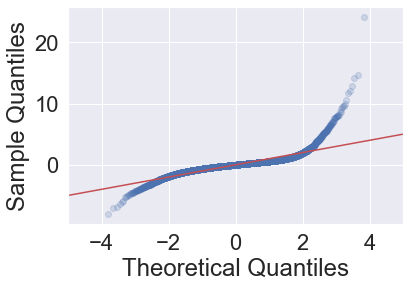

In [36]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_vanilla.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [37]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_vanilla.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_vanilla.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))


Train RMSE: 147456.8717178262 
 Test RMSE: 157877.62035823576
Percent change:  7.067


In [25]:
# Our test model is actually not far off, especially for the vanilla model.
# That being said, RMSE seems high. I think we can bring this down...
# especially by removing outliers and collinearity

### Model 2: Removing Outliers

In [27]:
# Going to remove outliers based on 2 standard deviations (95%)
# This is because our business focus is not on the most expensive or the cheapest homes.
# So in order to improve our model's prediction for relevant prices, we'll narrow our scope
# Down the line, I'd like to look at zipcodes and schools/bus stop data to see if that correlates with price
# If so, maybe we focus on those homes.
# Otherwise, let's see how renovations predicts pricing

Based on the results below for standard deviation of pricing, it would be inaccurate to filter our training and testing sets based on their own respective standard deviation since they will differ.

Therefore, to maintain consistency without training the original training set, we will filter both training and testing data based on 2 standard deviations from the mean from the overall dataset. This is effectively the same results as removing the pricing outliers before train_test_split.

In [19]:
# Here is our code for filtering the training set based on 2 std from full dataset
# We can see the before and after to verify that outliers have been trimmed
mean_price = np.mean(upHouse_data.price, axis=0)
sd_price = np.std(upHouse_data.price, axis=0)

final_y_train_list = [y for y in y_train if (y > mean_price - 2 * sd_price)]
final_y_train_list = [y for y in final_y_train_list if (y < mean_price + 2 * sd_price)]
y_train_2std = pd.Series(final_y_train_list)

#### Comparison of y_train set before and after filtering for 2 standard deviations for price from the full dataset:

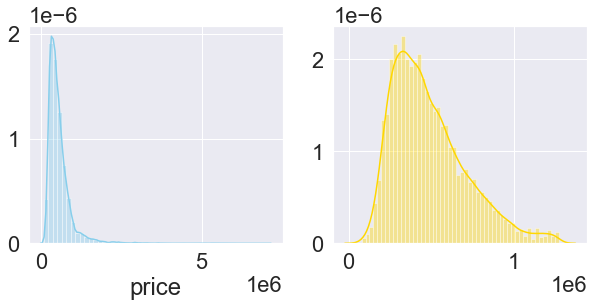

In [20]:
sns.set(font_scale=2) 
f, axes = plt.subplots(1, 2, figsize=(10,4));
sns.distplot(y_train, color="skyblue", ax=axes[0])
sns.distplot(y_train_2std, color="gold", ax=axes[1]);

In [39]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
# Practicing on dataset. Will then apply to our y_train/y_test data 
upHouse_data_2std = upHouse_data[(np.abs(stats.zscore(upHouse_data.price)) < 2)]

# How many rows were removed & how many rows are left
print(len(upHouse_data.index.difference(upHouse_data_2std.index)))
len(upHouse_data_2std)

841


20756

In [223]:
X = upHouse_data_2std[feat_cols]
y = upHouse_data_2std['price']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [42]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [43]:
training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     772.2
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:52:17   Log-Likelihood:            -1.8644e+05
No. Observations:               14529   AIC:                         3.731e+05
Df Residuals:                   14432   BIC:                         3.738e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.279e+05   1.28e+05      6.452      0.000    5.76e+05    1.08e+06
bedrooms       -2457.3428   1074.726     -2.286      0.022   -4563.944    -350.741
bathrooms       1.497e+04   1873.174      7.990      0.000    1.13e+04    1.86e+04
sqft_living       46.1241     10.303      4.477      0.000      25.929      66.319
floors         -1.916e+04   2235.893     -8.568      0.000   -2.35e+04   -1.48e+04
waterfront      1.623e+05   1.63e+04      9.950      0.000     1.3e+05    1.94e+05
sqft_above        69.4338     10.320      6.728      0.000      49.205      89.663
sqft_basement     26.0420     10.203      2.552      0.011       6.043      46.041
yr_built        -421.6853     45.840     -9.199      0.000    -511.538    -331.833
renovated       3.937e+04   4661.579      8.446      0.000    3.02e+04    4.85e+04
sqft_living15     33.0512      2.138     15.458      0.000      28.860      37.242
cond__2         6.859e+04   2.21e+04      3.096      0.002    2.52e+04    1.12e+05
cond__3         8.394e+04   2.06e+04      4.065      0.000    4.35e+04    1.24e+05
cond__4         1.052e+05   2.07e+04      5.092      0.000    6.47e+04    1.46e+05
cond__5          1.39e+05   2.08e+04      6.687      0.000    9.83e+04     1.8e+05
grade__4       -1.196e+05   9.38e+04     -1.275      0.203   -3.03e+05    6.43e+04
grade__5       -1.247e+05   9.14e+04     -1.364      0.173   -3.04e+05    5.45e+04
grade__6       -1.186e+05   9.12e+04     -1.300      0.194   -2.97e+05    6.02e+04
grade__7        -9.35e+04   9.12e+04     -1.025      0.305   -2.72e+05    8.53e+04
grade__8       -5.271e+04   9.12e+04     -0.578      0.563   -2.32e+05    1.26e+05
grade__9         2.06e+04   9.13e+04      0.226      0.822   -1.58e+05       2e+05
grade__10       7.281e+04   9.14e+04      0.797      0.426   -1.06e+05    2.52e+05
grade__11       1.478e+05   9.17e+04      1.611      0.107    -3.2e+04    3.28e+05
grade__12       1.833e+05      1e+05      1.831      0.067    -1.3e+04     3.8e+05
grade__13       2.061e-09   4.19e-10      4.912      0.000    1.24e-09    2.88e-09
view__1.0       5.686e+04   6928.918      8.206      0.000    4.33e+04    7.04e+04
view__2.0       6.023e+04   4121.062     14.614      0.000    5.21e+04    6.83e+04
view__3.0        1.06e+05   5775.338     18.353      0.000    9.47e+04    1.17e+05
view__4.0       1.825e+05   9155.272     19.929      0.000    1.65e+05       2e+05
zipcode__98002  5725.2902   9717.236      0.589      0.556   -1.33e+04    2.48e+04
zipcode__98003 -5556.1521   8718.041     -0.637      0.524   -2.26e+04    1.15e+04
zipcode__98004  5.345e+05      1e+04     53.369      0.000    5.15e+05    5.54e+05
zipcode__98005  3.371e+05   1.03e+04     32.629      0.000    3.17e+05    3.57e+05
zipcode__98006  2.687e+05   7861.802     34.175      0.000    2.53e+05    2.84e+05
zipcode__980

In [44]:
model_outliers = sm.OLS(y_train, X_train).fit()

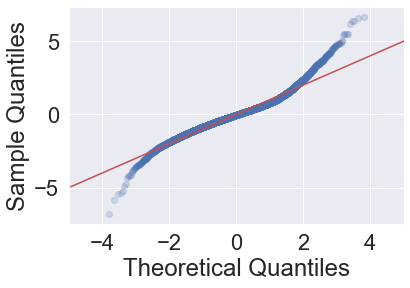

In [45]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_outliers.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [50]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_outliers.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_outliers.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((90380.9479527678-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 90527.95345722274 
 Test RMSE: 90380.9479527678
Percent change:  -0.162
Percent change (Base Model vs. Model-Outliers Removed):  -42.753


Adjusted R-squared improved by .003 to .836

RMSE decreased by 42.753% showing significant error reduction

In [51]:
upHouse_data_2std.price.describe()

count    2.075600e+04
mean     4.877262e+05
std      2.244543e+05
min      7.800000e+04
25%      3.170000e+05
50%      4.400000e+05
75%      6.132750e+05
max      1.270000e+06
Name: price, dtype: float64

### Model: Further Price Narrowing

In [224]:
upHouse_data_prim = upHouse_data_2std[upHouse_data_2std['price'] <= 790000]

In [209]:
X = upHouse_data_prim[feat_cols]
y = upHouse_data_prim['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     557.2
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:37:55   Log-Likelihood:            -1.6303e+05
No. Observations:               12958   AIC:                         3.263e+05
Df Residuals:                   12862   BIC:                         3.270e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.774e+05   1.04e+05      6.528      0.000    4.74e+05    8.81e+05
bedrooms       -3111.1964    971.725     -3.202      0.001   -5015.921   -1206.471
bathrooms        1.38e+04   1592.865      8.661      0.000    1.07e+04    1.69e+04
sqft_living       59.7914      9.390      6.368      0.000      41.386      78.197
floors         -1.828e+04   1864.476     -9.805      0.000   -2.19e+04   -1.46e+04
waterfront      1.062e+05   1.73e+04      6.151      0.000    7.23e+04     1.4e+05
sqft_above        34.6863      9.413      3.685      0.000      16.236      53.137
sqft_basement     -0.0915      9.305     -0.010      0.992     -18.331      18.148
yr_built        -334.2369     38.646     -8.649      0.000    -409.989    -258.484
renovated        1.76e+04   4058.451      4.336      0.000    9643.396    2.56e+04
sqft_living15     32.5765      1.903     17.118      0.000      28.846      36.307
cond__2         5.047e+04   1.77e+04      2.858      0.004    1.59e+04    8.51e+04
cond__3         8.035e+04   1.65e+04      4.865      0.000     4.8e+04    1.13e+05
cond__4         9.753e+04   1.65e+04      5.903      0.000    6.51e+04     1.3e+05
cond__5         1.258e+05   1.66e+04      7.563      0.000    9.32e+04    1.58e+05
grade__4        -1.13e+05    7.3e+04     -1.547      0.122   -2.56e+05    3.02e+04
grade__5       -1.032e+05   7.12e+04     -1.449      0.147   -2.43e+05    3.64e+04
grade__6         -9.1e+04    7.1e+04     -1.282      0.200    -2.3e+05    4.82e+04
grade__7       -6.079e+04    7.1e+04     -0.856      0.392      -2e+05    7.84e+04
grade__8       -2.378e+04    7.1e+04     -0.335      0.738   -1.63e+05    1.15e+05
grade__9        2.584e+04   7.11e+04      0.363      0.716   -1.14e+05    1.65e+05
grade__10       4.898e+04   7.13e+04      0.687      0.492   -9.07e+04    1.89e+05
grade__11       4.836e+04    7.3e+04      0.662      0.508   -9.47e+04    1.91e+05
grade__12       6.577e-09   6.22e-10     10.575      0.000    5.36e-09     7.8e-09
grade__13      -5.353e-09   5.69e-10     -9.401      0.000   -6.47e-09   -4.24e-09
view__1.0       4.143e+04   6025.288      6.876      0.000    2.96e+04    5.32e+04
view__2.0       4.515e+04   3576.783     12.624      0.000    3.81e+04    5.22e+04
view__3.0       6.987e+04   5465.134     12.785      0.000    5.92e+04    8.06e+04
view__4.0       1.152e+05    1.2e+04      9.590      0.000    9.16e+04    1.39e+05
zipcode__98002 -1640.1232   7404.636     -0.221      0.825   -1.62e+04    1.29e+04
zipcode__98003 -4441.5697   6729.372     -0.660      0.509   -1.76e+04    8748.999
zipcode__98004  4.163e+05   1.18e+04     35.260      0.000    3.93e+05    4.39e+05
zipcode__98005  2.898e+05   9947.853     29.127      0.000     2.7e+05    3.09e+05
zipcode__98006  2.318e+05   6837.506     33.907      0.000    2.18e+05    2.45e+05
zipcode__980

In [192]:
model_prim = sm.OLS(y_train, X_train).fit()

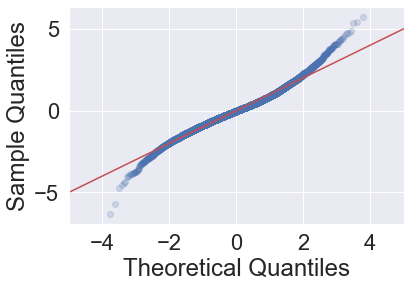

In [193]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_prim.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [194]:
# QQ Plot has heavy tails especially on the high-end. 
# Further trimming may be warranted. But first, let's work with what we got.

In [195]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_prim.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_prim.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 70444.71741170423 
 Test RMSE: 71691.36133659256
Percent change:  1.77
Percent change (Base Model vs. Model-Outliers Removed):  -54.591


Woah... that's better than I thought it would be. Slight decrease in R-squared but reduced error and close predictions between train and test sets.

QQ plot is still a little sad

### Model: Dummy Bedrooms

### Model: Binning Bathrooms

Working from the prim dataset (2std deviations removed from low end, and price cut off at <= 1,000,000)

##### Update: No improvement. To the Appendix with you!

In [225]:
bins = [0,1,2,3,4,5,6,7,8]
upHouse_data_prim['bathroom_bins'] = pd.cut(upHouse_data_prim['bathrooms'], bins ,include_lowest = True)

<ipython-input-225-922f3709db6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upHouse_data_prim['bathroom_bins'] = pd.cut(upHouse_data_prim['bathrooms'], bins ,include_lowest = True)


In [226]:
upHouse_data_prim['bathroom_bins'] = upHouse_data_prim['bathroom_bins'].cat.codes
upHouse_data_prim['bathroom_bins'].value_counts()

<ipython-input-226-cc44b35ac9de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upHouse_data_prim['bathroom_bins'] = upHouse_data_prim['bathroom_bins'].cat.codes


2    7846
1    6083
0    3864
3     673
4      42
5       3
7       1
Name: bathroom_bins, dtype: int64

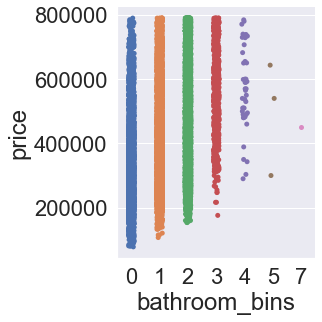

In [227]:
sns.catplot(x="bathroom_bins", y="price", data=upHouse_data_prim);

In [228]:
upHouse_data_prim.drop('bathrooms', axis=1, inplace=True)

In [230]:
# Update column names
feat_cols = list(upHouse_data_prim.columns)
feat_cols.remove(outcome)

In [231]:
X = upHouse_data_prim[feat_cols]
y = upHouse_data_prim['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     557.1
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:42:30   Log-Likelihood:            -1.6303e+05
No. Observations:               12958   AIC:                         3.263e+05
Df Residuals:                   12862   BIC:                         3.270e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.817e+05   1.04e+05      6.558      0.000    4.78e+05    8.85e+05
bedrooms       -2745.9432    965.169     -2.845      0.004   -4637.817    -854.069
sqft_living       60.3736      9.385      6.433      0.000      41.977      78.770
floors         -1.921e+04   1892.535    -10.148      0.000   -2.29e+04   -1.55e+04
waterfront      1.051e+05   1.73e+04      6.090      0.000    7.13e+04    1.39e+05
sqft_above        34.7151      9.413      3.688      0.000      16.263      53.167
sqft_basement     -0.5679      9.306     -0.061      0.951     -18.810      17.674
yr_built        -331.1592     38.574     -8.585      0.000    -406.769    -255.549
renovated       1.857e+04   4049.339      4.587      0.000    1.06e+04    2.65e+04
sqft_living15     32.4262      1.904     17.035      0.000      28.695      36.157
cond__2         5.067e+04   1.77e+04      2.869      0.004    1.61e+04    8.53e+04
cond__3         8.048e+04   1.65e+04      4.873      0.000    4.81e+04    1.13e+05
cond__4         9.749e+04   1.65e+04      5.900      0.000    6.51e+04     1.3e+05
cond__5         1.263e+05   1.66e+04      7.594      0.000    9.37e+04    1.59e+05
grade__4       -1.104e+05    7.3e+04     -1.511      0.131   -2.54e+05    3.28e+04
grade__5       -1.003e+05   7.12e+04     -1.409      0.159    -2.4e+05    3.93e+04
grade__6       -8.833e+04    7.1e+04     -1.244      0.214   -2.28e+05    5.09e+04
grade__7        -5.89e+04    7.1e+04     -0.829      0.407   -1.98e+05    8.03e+04
grade__8       -2.217e+04    7.1e+04     -0.312      0.755   -1.61e+05    1.17e+05
grade__9        2.762e+04   7.11e+04      0.388      0.698   -1.12e+05    1.67e+05
grade__10       5.128e+04   7.13e+04      0.720      0.472   -8.84e+04    1.91e+05
grade__11       5.096e+04    7.3e+04      0.698      0.485   -9.22e+04    1.94e+05
grade__12      -3.871e-09   3.86e-10    -10.024      0.000   -4.63e-09   -3.11e-09
grade__13       5.467e-09   5.12e-10     10.683      0.000    4.46e-09    6.47e-09
view__1.0        4.14e+04   6025.681      6.871      0.000    2.96e+04    5.32e+04
view__2.0        4.53e+04   3576.891     12.665      0.000    3.83e+04    5.23e+04
view__3.0       7.027e+04   5465.259     12.858      0.000    5.96e+04     8.1e+04
view__4.0       1.158e+05    1.2e+04      9.642      0.000    9.23e+04    1.39e+05
zipcode__98002 -1723.9593   7405.181     -0.233      0.816   -1.62e+04    1.28e+04
zipcode__98003 -4688.5723   6730.141     -0.697      0.486   -1.79e+04    8503.503
zipcode__98004  4.167e+05   1.18e+04     35.284      0.000    3.94e+05     4.4e+05
zipcode__98005   2.89e+05   9950.413     29.046      0.000     2.7e+05    3.09e+05
zipcode__98006  2.311e+05   6837.823     33.797      0.000    2.18e+05    2.45e+05
zipcode__98007  2.364e+05   9449.731     25.016      0.000    2.18e+05    2.55e+05
zipcode__980

In [232]:
model_prim_bin = sm.OLS(y_train, X_train).fit()

In [233]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_prim_bin.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_prim_bin.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 70448.84008612919 
 Test RMSE: 71761.20392343133
Percent change:  1.863
Percent change (Base Model vs. Model-Outliers Removed):  -54.546


### Model 3: Log Transformation to Price (y-variable)


In [41]:
# Transform y_train_out and y_test_out with np.log
y_train_log = np.log(y_train_out)
y_test_log = np.log(y_test_out)
# Check that Model 2 and Model 3's y variables match
print(len(y_train_log), len(y_train_out))

14529 14529


In [42]:
training_model(feat_cols, outcome, y_train_log, X_train_out)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     829.6
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:25:51   Log-Likelihood:                 4372.9
No. Observations:               14529   AIC:                            -8552.
Df Residuals:                   14432   BIC:                            -7816.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.2819      0.254     52.329      0.000      12.784      13.779
bedrooms          -0.0032      0.002     -1.498      0.134      -0.007       0.001
bathrooms          0.0356      0.004      9.606      0.000       0.028       0.043
sqft_living        0.0001   2.04e-05      5.274      0.000    6.75e-05       0.000
floors            -0.0383      0.004     -8.669      0.000      -0.047      -0.030
waterfront         0.3702      0.032     11.471      0.000       0.307       0.433
sqft_above         0.0001   2.04e-05      5.746      0.000    7.73e-05       0.000
sqft_basement   3.135e-05   2.02e-05      1.553      0.120   -8.21e-06    7.09e-05
yr_built          -0.0007   9.07e-05     -7.991      0.000      -0.001      -0.001
renovated          0.0633      0.009      6.863      0.000       0.045       0.081
sqft_living15   8.382e-05   4.23e-06     19.817      0.000    7.55e-05    9.21e-05
cond__2            0.0930      0.044      2.123      0.034       0.007       0.179
cond__3            0.2052      0.041      5.024      0.000       0.125       0.285
cond__4            0.2475      0.041      6.057      0.000       0.167       0.328
cond__5            0.3058      0.041      7.438      0.000       0.225       0.386
grade__4          -0.4492      0.186     -2.421      0.015      -0.813      -0.086
grade__5          -0.3998      0.181     -2.211      0.027      -0.754      -0.045
grade__6          -0.2904      0.180     -1.610      0.108      -0.644       0.063
grade__7          -0.1687      0.180     -0.935      0.350      -0.522       0.185
grade__8          -0.0729      0.180     -0.404      0.686      -0.427       0.281
grade__9           0.0141      0.181      0.078      0.938      -0.340       0.368
grade__10          0.0306      0.181      0.169      0.866      -0.324       0.385
grade__11          0.0202      0.181      0.111      0.911      -0.335       0.376
grade__12         -0.0368      0.198     -0.186      0.853      -0.425       0.352
grade__13       1.118e-14    8.3e-16     13.473      0.000    9.55e-15    1.28e-14
view__1.0          0.1004      0.014      7.328      0.000       0.074       0.127
view__2.0          0.1063      0.008     13.042      0.000       0.090       0.122
view__3.0          0.1721      0.011     15.066      0.000       0.150       0.195
view__4.0          0.2339      0.018     12.913      0.000       0.198       0.269
zipcode__98002    -0.0378      0.019     -1.967      0.049      -0.075      -0.000
zipcode__98003    -0.0094      0.017     -0.544      0.587      -0.043       0.024
zipcode__98004     1.0338      0.020     52.183      0.000       0.995       1.073
zipcode__98005     0.7262      0.020     35.533      0.000       0.686       0.766
zipcode__98006     0.6100      0.016     39.220      0.000       0.579       0.640
zipcode__980

In [43]:
model3_log = sm.OLS(y_train_log, X_train_out).fit()

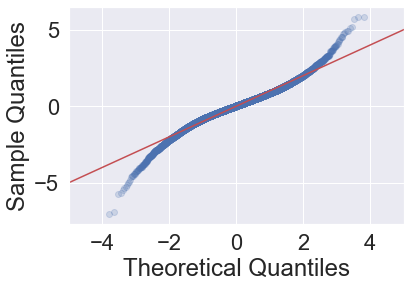

In [44]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model3_log.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [45]:
# We're still dealing with skew here... why
# Probably further trimming ($400,000 - $1,000,000)

In [46]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train3 = model3_log.predict(X_train_out)
rmse_train3 = mse(y_train_log, y_hat_train3)**0.5
y_hat_test3 = model3_log.predict(X_test_out)
rmse_test3 = mse(y_test_log, y_hat_test3)**0.5
print(f'Train RMSE: {rmse_train3} \n Test RMSE: {rmse_test3}')
print('Percent change: ', round(((rmse_test3-rmse_train3)/rmse_train3)*100, 3))

Train RMSE: 0.1790812593145423 
 Test RMSE: 0.18303977494852627
Percent change:  2.21


In [81]:
lessee3 = np.sqrt(mse(np.exp(y_train_log), np.exp(y_hat_train3)))
lessee3

92323.73128717011

In [ ]:
# Lower RMSEs since we log-transformed prices

### Model 4: Addressing Collinearity

In [47]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data_2std.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.5) & (coral.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.857486
"(cond__3, cond__4)",0.815930
"(sqft_living15, sqft_living)",0.743393
"(sqft_living, bathrooms)",0.723533
"(sqft_above, sqft_living15)",0.721484
"(bathrooms, sqft_above)",0.646387
"(sqft_living, price)",0.639734
"(bedrooms, sqft_living)",0.585192
"(sqft_living15, price)",0.579969


In [48]:
# Include price to determine which to keep
# Drop cond_3, yr_built, floors
# Interaction: Sqft_living+Sqft_above

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

sqft_above = upHouse_data_2std.sqft_above.values.reshape(-1, 1)
sqft_living = upHouse_data_2std.sqft_living.values.reshape(-1, 1)
sqft_living15 = upHouse_data_2std.sqft_living15.values.reshape(-1, 1)
price = upHouse_data_2std.price.values.reshape(-1, 1)


regression_1.fit(sqft_above, price)
regression_2.fit(sqft_living, price)
regression_3.fit(sqft_living15, price)

# Make predictions using the testing set
pred_1 = regression_1.predict(sqft_above)
pred_2 = regression_2.predict(sqft_living)
pred_3 = regression_2.predict(sqft_living15)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[[164.70243184]]
[[179.82941853]]
[[205.87981237]]


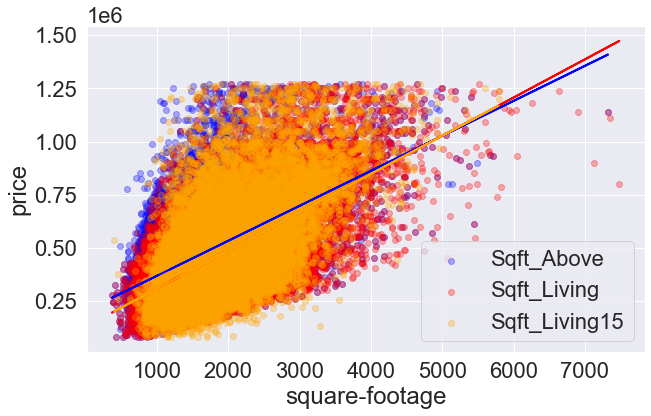

In [51]:
plt.figure(figsize=(10,6))

plt.scatter(sqft_above, upHouse_data_2std.price,  color='blue', alpha=0.3, label = 'Sqft_Above')
plt.scatter(sqft_living, upHouse_data_2std.price,  color='red', alpha=0.3, label = 'Sqft_Living')
plt.scatter(sqft_living15, upHouse_data_2std.price,  color='orange', alpha=0.3, label = 'Sqft_Living15')

plt.plot(sqft_above, pred_1, color='blue', linewidth=2)
plt.plot(sqft_living, pred_2, color='red', linewidth=2)
plt.plot(sqft_living15, pred_3, color='orange', linewidth=2)
plt.ylabel('price')
plt.xlabel('square-footage')
plt.legend();

In [61]:
X_interact_train = X_train_out.copy()
X_interact_test = X_test_out.copy()
X_interact_train['sqft_living-above'] = X_train_out['sqft_above'] * X_train_out['sqft_living']
X_interact_test['sqft_living-above'] = X_test_out['sqft_above'] * X_test_out['sqft_living']
X_interact_train.drop(columns=['sqft_living', 'sqft_above', 'sqft_living15'], inplace=True)
X_interact_test.drop(columns=['sqft_living', 'sqft_above', 'sqft_living15'], inplace=True)

In [62]:
# Drop cond_3, yr_built, floors, grade_7, grade_8
X_interact_train.drop(['cond__3', 'yr_built', 'floors', 'bathrooms', 'grade__7', 'grade__8'], axis=1, inplace=True)
X_interact_test.drop(['cond__3', 'yr_built', 'floors','bathrooms', 'grade__7', 'grade__8'], axis=1, inplace=True)

In [63]:
training_model(feat_cols, outcome, y_train_log, X_interact_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     710.9
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:11:15   Log-Likelihood:                 2914.3
No. Observations:               14529   AIC:                            -5651.
Df Residuals:                   14440   BIC:                            -4976.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.2197      0.014    861.994      0.000      12.192      12.247
bedrooms              0.0185      0.002      8.343      0.000       0.014       0.023
waterfront            0.3488      0.036      9.785      0.000       0.279       0.419
sqft_basement      8.523e-05   4.49e-06     18.972      0.000    7.64e-05     9.4e-05
renovated             0.0841      0.010      8.633      0.000       0.065       0.103
cond__2              -0.1224      0.019     -6.603      0.000      -0.159      -0.086
cond__4               0.0399      0.004      9.852      0.000       0.032       0.048
cond__5               0.1078      0.007     16.545      0.000       0.095       0.121
grade__4             -0.3902      0.049     -8.033      0.000      -0.485      -0.295
grade__5             -0.3189      0.016    -19.956      0.000      -0.350      -0.288
grade__6             -0.1888      0.006    -31.047      0.000      -0.201      -0.177
grade__9              0.1559      0.006     25.247      0.000       0.144       0.168
grade__10             0.1494      0.010     14.458      0.000       0.129       0.170
grade__11             0.0791      0.020      4.029      0.000       0.041       0.118
grade__12             0.0639      0.090      0.712      0.477      -0.112       0.240
grade__13          5.137e-10    4.1e-11     12.517      0.000    4.33e-10    5.94e-10
view__1.0             0.1518      0.015     10.061      0.000       0.122       0.181
view__2.0             0.1534      0.009     17.216      0.000       0.136       0.171
view__3.0             0.2402      0.013     19.190      0.000       0.216       0.265
view__4.0             0.3159      0.020     15.894      0.000       0.277       0.355
zipcode__98002       -0.0622      0.021     -2.932      0.003      -0.104      -0.021
zipcode__98003       -0.0018      0.019     -0.093      0.926      -0.039       0.036
zipcode__98004        1.0931      0.022     50.241      0.000       1.050       1.136
zipcode__98005        0.8099      0.022     36.065      0.000       0.766       0.854
zipcode__98006        0.6675      0.017     39.109      0.000       0.634       0.701
zipcode__98007        0.6678      0.024     27.821      0.000       0.621       0.715
zipcode__98008        0.6467      0.019     34.094      0.000       0.610       0.684
zipcode__98010        0.2632      0.026     10.122      0.000       0.212       0.314
zipcode__98011        0.4650      0.021     22.014      0.000       0.424       0.506
zipcode__98014        0.3684      0.025     14.922      0.000       0.320       0.417
zipcode__98019        0.3590      0.021     17.267      0.000       0.318       0.400
zipcode__98022        0.0645      0.020      3.259      0.001       0.026       0.103
zipcode__98023       -0.0172      0.016     -1.052      0.293      -0.049

In [64]:
model4_colin = sm.OLS(y_train_log, X_interact_train).fit()

In [65]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train4 = model4_colin.predict(X_interact_train)
rmse_train4 = mse(y_train_log, y_hat_train4)**0.5
y_hat_test4 = model4_colin.predict(X_interact_test)
rmse_test4 = mse(y_test_log, y_hat_test4)**0.5
print(f'Train RMSE: {rmse_train4} \n Test RMSE: {rmse_test4}')
print('Percent change: ', round(((rmse_test4-rmse_train4)/rmse_train4)*100, 3))

Train RMSE: 0.19799308307521132 
 Test RMSE: 0.2048465922537952
Percent change:  3.461


In [78]:
lessee2 = np.sqrt(mse(np.exp(y_train_log), np.exp(y_hat_train4)))

In [79]:
lessee2

112719.59984391986

### Model 5: Eliminating Non-Sig P-Values

In [66]:
# Extract the p-value table from the summary and use it to subset our features
summary = model4_colin.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
# x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

90 85
['const', 'bedrooms', 'waterfront', 'sqft_basement', 'renovated']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
const,12.2197,0.014,861.994,0.0,12.192,12.247
bedrooms,0.0185,0.002,8.343,0.0,0.014,0.023
waterfront,0.3488,0.036,9.785,0.0,0.279,0.419
sqft_basement,8.523e-05,4.49e-06,18.972,0.0,7.64e-05,9.4e-05
renovated,0.0841,0.010,8.633,0.0,0.065,0.103


In [67]:
len(p_table)

90

In [68]:
X_train_psig = X_interact_train[x_cols]
X_test_psig = X_interact_test[x_cols]

In [70]:
len(X_train_psig)

14529

In [71]:
model5 = sm.OLS(y_train_log, X_train_psig).fit() 

In [72]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     753.6
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:20:52   Log-Likelihood:                 2910.6
No. Observations:               14529   AIC:                            -5653.
Df Residuals:                   14445   BIC:                            -5016.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.2211      0.009   1364.034      0.000      12.204      12.239
bedrooms              0.0185      0.002      8.321      0.000       0.014       0.023
waterfront            0.3500      0.036      9.829      0.000       0.280       0.420
sqft_basement      8.538e-05   4.49e-06     19.022      0.000    7.66e-05    9.42e-05
renovated             0.0844      0.010      8.665      0.000       0.065       0.103
cond__2              -0.1221      0.019     -6.587      0.000      -0.158      -0.086
cond__4               0.0396      0.004      9.775      0.000       0.032       0.047
cond__5               0.1077      0.007     16.538      0.000       0.095       0.121
grade__4             -0.3900      0.049     -8.029      0.000      -0.485      -0.295
grade__5             -0.3168      0.016    -19.862      0.000      -0.348      -0.286
grade__6             -0.1875      0.006    -31.103      0.000      -0.199      -0.176
grade__9              0.1555      0.006     25.228      0.000       0.143       0.168
grade__10             0.1487      0.010     14.422      0.000       0.128       0.169
grade__11             0.0784      0.020      3.997      0.000       0.040       0.117
grade__13          7.162e-11    4.7e-12     15.223      0.000    6.24e-11    8.08e-11
view__1.0             0.1526      0.015     10.120      0.000       0.123       0.182
view__2.0             0.1539      0.009     17.284      0.000       0.136       0.171
view__3.0             0.2416      0.012     19.346      0.000       0.217       0.266
view__4.0             0.3167      0.020     15.934      0.000       0.278       0.356
zipcode__98002       -0.0637      0.018     -3.506      0.000      -0.099      -0.028
zipcode__98004        1.0920      0.019     58.082      0.000       1.055       1.129
zipcode__98005        0.8089      0.020     41.242      0.000       0.770       0.847
zipcode__98006        0.6671      0.013     51.128      0.000       0.642       0.693
zipcode__98007        0.6669      0.021     31.201      0.000       0.625       0.709
zipcode__98008        0.6455      0.015     41.679      0.000       0.615       0.676
zipcode__98010        0.2618      0.024     11.096      0.000       0.216       0.308
zipcode__98011        0.4639      0.018     25.634      0.000       0.428       0.499
zipcode__98014        0.3669      0.022     16.576      0.000       0.324       0.410
zipcode__98019        0.3577      0.018     20.199      0.000       0.323       0.392
zipcode__98022        0.0630      0.016      3.817      0.000       0.031       0.095
zipcode__98024        0.4473      0.028     16.011      0.000       0.393       0.502
zipcode__98027        0.5435      0.013     41.162      0.000       0.518       0.569
zipcode__98028        0.4300      0.015     28.619      0.000       0.401

In [73]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train5 = model5.predict(X_train_psig)
rmse_train5 = mse(y_train_log, y_hat_train5)**0.5
y_hat_test5 = model5.predict(X_test_psig)
rmse_test5 = mse(y_test_log, y_hat_test5)**0.5
print(f'Train RMSE: {rmse_train5} \n Test RMSE: {rmse_test5}')
print('Percent change: ', round(((rmse_test5-rmse_train5)/rmse_train5)*100, 3))

Train RMSE: 0.19804276873669566 
 Test RMSE: 0.20489478651345225
Percent change:  3.46


In [77]:
lessee = np.sqrt(mse(np.exp(y_train_log), np.exp(y_hat_train5)))
lessee

112735.06083938933

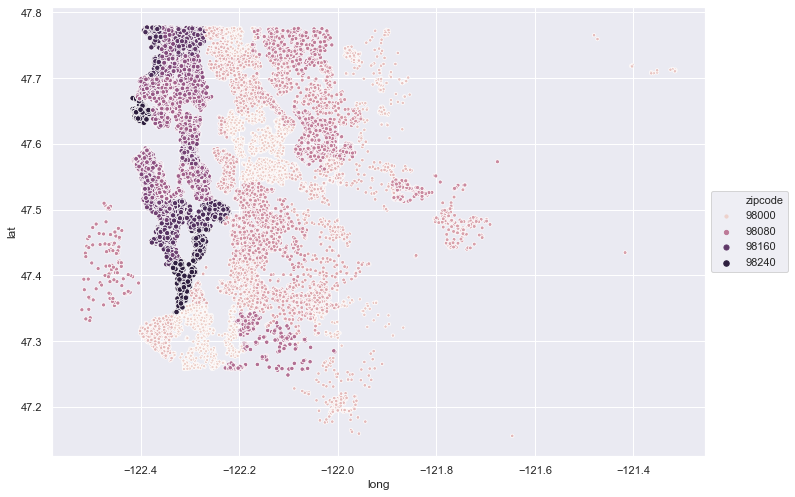

In [85]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(house_data.long, house_data.lat, hue=house_data.zipcode, size=house_data.zipcode,
    sizes=(10, 30))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);

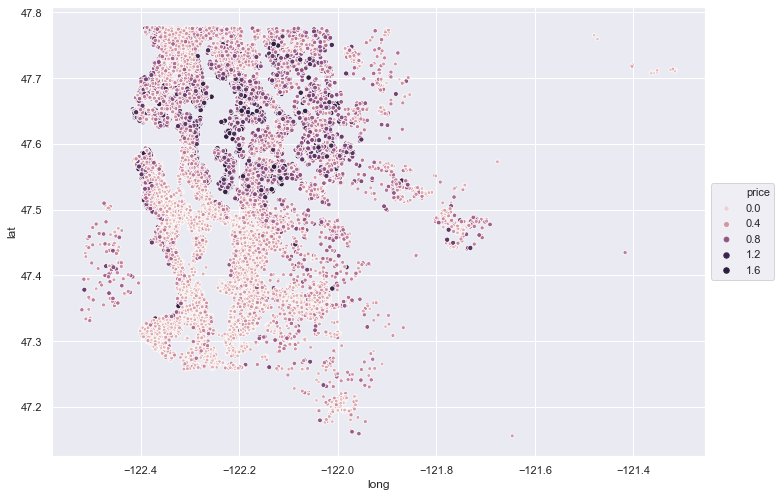

In [83]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(upHouse_data_2std.long, upHouse_data_2std.lat, hue=upHouse_data_2std.price, size=upHouse_data_2std.price,
    sizes=(10, 30))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);